In [153]:
import pandas as pd
import numpy as np 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, log_loss, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
import category_encoders as ce
from numpy.testing import assert_almost_equal
from functools import reduce
import matplotlib.pyplot as plt
import time
from category_encoders.binary import BinaryEncoder
pd.set_option('display.max_columns', None)  # Unlimited columns
import xgboost as xgb
import copy

In [154]:
xgb.__version__

'0.81'

In [155]:
url = "unit-3/train_features.csv"
df = pd.read_csv(url, parse_dates=['date_recorded'],index_col='id' )

In [156]:
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [157]:
df.shape

(59400, 39)

In [158]:
df['timestamp'] = df.date_recorded.apply(lambda d: d.timestamp()/ 10 ** 9)
df_ = df.drop(['date_recorded', 'region_code', 'district_code', 'region'], inplace = False, axis=1)
df_['region_district'] = df.apply(lambda row: f'{row.region}_{row.district_code}' , axis=1)
train_input_columns = list(df_.columns)
train_numeric_columns = df_.select_dtypes(exclude=['object']).columns
df_.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,timestamp,region_district
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1.300061,Iringa_5
8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.362528,Mara_2
34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1.361750,Manyara_4
67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1.359331,Mtwara_63
19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.310515,Kagera_1


In [159]:
df_.shape

(59400, 37)

In [175]:
dc = 'status_group'

In [176]:
yurl = 'unit-3/train_labels.csv'
dfy = pd.read_csv(yurl, index_col='id' )
dfy.shape
y = dfy[dc]

In [177]:
y.shape

(59400,)

In [178]:
oc = df_.select_dtypes(include=['object']).columns
oc

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'lga', 'ward',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'region_district'],
      dtype='object')

In [179]:
hot = []
binary = []
for o in oc:
    if df_[o].unique().shape[0] > 127:
        print(df_[o].unique().shape[0], o)
        binary.append(o)
    else:
        hot.append(o)

1898 funder
2146 installer
37400 wpt_name
19288 subvillage
2092 ward
2697 scheme_name
132 region_district


In [180]:
test_url = "unit-3/test_features.csv"
df = pd.read_csv(test_url, parse_dates=['date_recorded'],index_col='id' )
df['timestamp'] = df.date_recorded.apply(lambda d: d.timestamp()/ 10 ** 9)
dft = df.drop(['date_recorded', 'region_code', 'district_code', 'region'], inplace = False, axis=1)
dft['region_district'] = df.apply(lambda row: f'{row.region}_{row.district_code}' , axis=1)
test_input_columns = list(dft.columns)
# dft[dc] = ['fuctional'] * dft.shape[0]
dft.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,timestamp,region_district
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,1.359936,Manyara_3
51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,1.359936,Arusha_2
17168,0.0,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,1.359677,Singida_2
45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,1.358813,Lindi_43
49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1.364342,Ruvuma_3


In [181]:
dft.shape, df_.shape

((14358, 37), (59400, 37))

In [182]:
# pd.set_option('display.max_columns', None)
#train__ = copy.deepcopy(train_input_columns)
# test_input_columns = df_.columns
test__ = list(dft.columns)
for c in train_input_columns:
    if c not in test_input_columns:
        print(f'{c} not in test')
    else:
        test__.remove(c)
print(test__)
        
    

[]


In [192]:
encoders = Pipeline([
                ('binary', BinaryEncoder(cols=binary)),
                ('onehot', ce.OneHotEncoder(use_cat_names=True,cols=hot))
            ])
df_l = df_.shape[0]
both = pd.concat([df_,dft])
print(df_l)
both.head()


59400


,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,timestamp,region_district
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1.300061,Iringa_5
8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.362528,Mara_2
34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1.361750,Manyara_4
67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1.359331,Mtwara_63
19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.310515,Kagera_1


In [188]:
both.shape

(73758, 37)

In [191]:
both_  = encoders.fit_transform(both)

(59400, (73758, 404), (59400, 376), (14358, 404))

In [194]:
df__  = both_.iloc[0:df_l]
dft_ = both_.iloc[df_l:]
df_l, both_.shape, df__.shape, dft_.shape

(59400, (73758, 404), (59400, 404), (14358, 404))

In [195]:
de = df__.describe()
de_test = dft_.describe()
ex_oc = df__.columns
drop = []
for o in ex_oc:
    if o in de.columns:
        if de[o]['mean'] == 0 and de_test[o]['mean'] == 0:
            drop.append(o)
        # print(de[o].mean)
X  = df__.drop(drop, axis=1)
dfp = dft_.drop(drop, axis=1)
print(drop)

['basin_-1', 'lga_-1', 'public_meeting_-1', 'recorded_by_-1', 'scheme_management_-1', 'permit_-1', 'extraction_type_-1', 'extraction_type_group_-1', 'extraction_type_class_-1', 'management_-1', 'management_group_-1', 'payment_-1', 'payment_type_-1', 'water_quality_-1', 'quality_group_-1', 'quantity_-1', 'quantity_group_-1', 'source_-1', 'source_type_-1', 'source_class_-1', 'waterpoint_type_-1', 'waterpoint_type_group_-1', 'funder_0', 'installer_0', 'wpt_name_0', 'subvillage_0', 'ward_0', 'scheme_name_0', 'region_district_0']


In [196]:
# read in data

df_y = pd.DataFrame(y)
print(df_y[df_y.status_group == 'functional needs repair'].shape)
print(df_y[df_y.status_group == 'functional'].shape)
print(df_y[df_y.status_group == 'non functional'].shape)
y_true = [1 if s == 'functional needs repair' else (2 if s == 'functional' else 3) 
                              for s in df_y[dc].values]
# scle = scl.fit(X)
# Xs = scl.transform(X)
dtrain = xgb.DMatrix(X, label=y_true)
# specify parameters via map
# param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'reg:linear' }
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 20
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 20
# param['tree_method'] = 'gpu_exact'
num_round = 25
bst = xgb.train(param, dtrain, num_round)
# make prediction
# dfps = scl.transform(dfp)
test = xgb.DMatrix(dfp)

preds = bst.predict(test)


(4317, 1)
(32259, 1)
(22824, 1)


In [197]:
dfp.shape

(14358, 375)

In [198]:
vpreds = bst.predict(xgb.DMatrix(X))
print(r2_score(y_true, vpreds))
print(accuracy_score(y_true, vpreds))

0.808840803091
0.943434343434


In [199]:
with open('testxgb.csv', 'w') as f:
    f.write('id,status_group\n')
    for fu,i in zip(preds, dfp.index):
        index = round(fu)
        d = 'non functional' if index == 3 else ('functional' if index == 2 else 'functional needs repair')
        f.write(f"{i},{d}")
        f.write('\n')

In [129]:
dfum[dc].iloc[0:5][8776]

'functional'

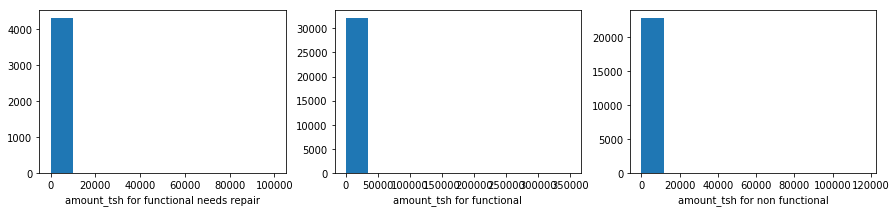

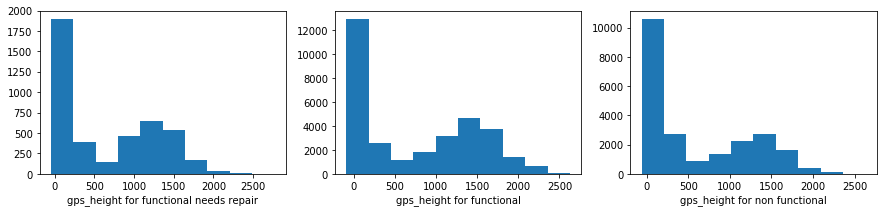

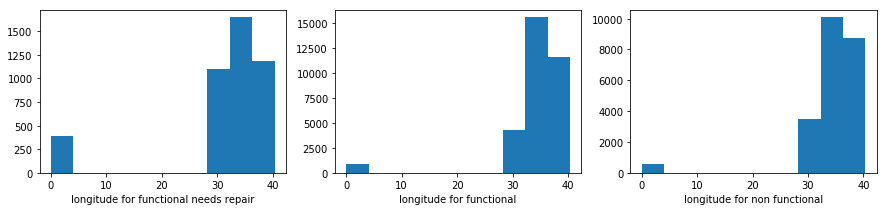

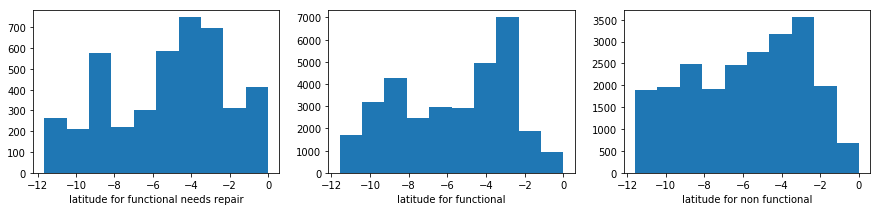

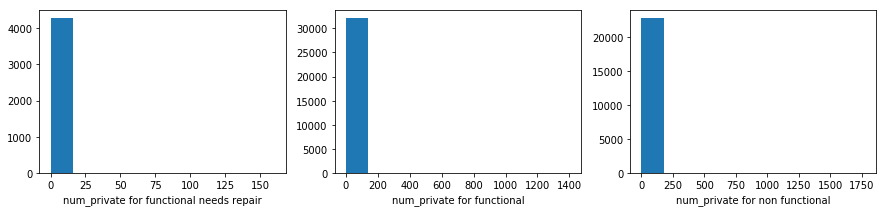

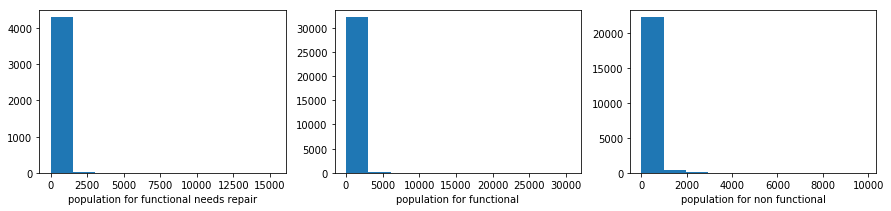

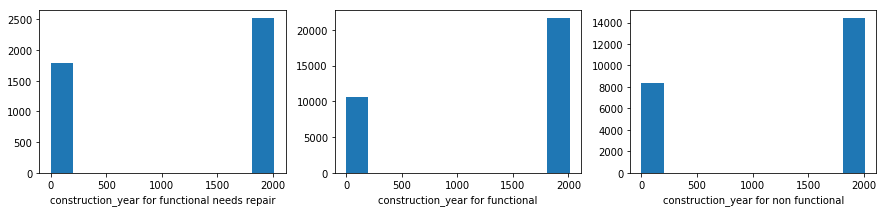

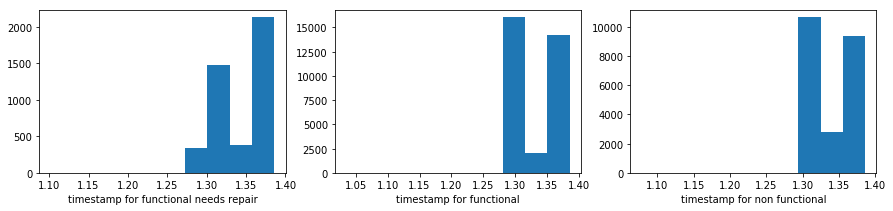

In [130]:
independant_columns  = dfum.select_dtypes(exclude=['object']).columns
one = 'functional needs repair'
two = 'functional'
three = 'non functional'
for c in independant_columns:
    fig, axs = plt.subplots(ncols=3)
    fig.set_size_inches(15, 3)
    axs[0].hist(dfum[dfum[dc] == one][c])
    axs[1].hist(dfum[dfum[dc] == two][c])
    axs[2].hist(dfum[dfum[dc] == three][c])
    axs[0].set_xlabel(f'{c} for functional needs repair')
    axs[1].set_xlabel(f"{c} for functional")
    axs[2].set_xlabel(f"{c} for non functional")
    plt.show()